#  Install package

In [829]:
# ! pip install pyvis
# ! pip install networkx
# ! pip install dash
# ! pip install altair
# ! pip install panel

# Import package

In [830]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
import openai
from IPython.display import display, HTML, Code
from IPython.display import clear_output


# Define Solution class
Please run the following cell to define the functions

In [831]:
# %load_ext autoreload
# %autoreload 2

import LLM_Geo_Constants as constants
import helper
# import LLM_Geo_kernel.Solution as Solution

from LLM_Geo_kernel import Solution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demonstration Cases

## Input task and data desciption

In [832]:
# Case 1: population living near hazardous wastes

# task_name ='Resident_at_risk_counting'

# TASK = r"""1) Find out the total population that lives within a tract that contain hazardous waste facilities. The study area is North Carolina, US.
# 2) Generate a map to show the spatial distribution of population at the tract level and highlight the borders of tracts that have hazardous waste facilities.
# """

# DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file location: https://github.com/gladcolor/LLM- Geo/raw/master/overlay_analysis/Hazardous_Waste_Sites.zip.",
#                   "NC tract boundary shapefile location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_shp_37.zip. The tract id column is 'Tract'.",
#                   "NC tract population CSV file location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID'."
#                  ]


# Case 2: France_mobility_changes_2020
task_name ='France_mobility_changes_2020'
TASK = r'''
1) Show the 2020 human mobility monthly change rates of each administrative regions in a France map. Each month is a sub-map in a map matrix. The base of the change rate is January 2020. 
2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line, the x-axis is 2020 months.
'''

DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
                  "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. " + \
                  "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
                  "REST API url with parameters for human mobility data access:" + \
                  "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
                  "The response is in CSV format. There are three columns in the response: " + \
                  "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code of every country; codes for France administrative regions start with 'FRA'.",
                 ]

  
# Case 3: COVID-19 prevalence trend
# task_name ='COVID_death_rate'
# TASK = r'''1) Draw a map to show the death rate (death/case) of COVID-19 among the countiguous US counties. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate. Use scheme ='quantiles' when plotting the map.  Set map projection to 'Conus Albers'. Set map size to 15*10 inches.  
# 2) Draw a scatter plot to show the correlation and trend line of the death rate with the senior resident rate, including the r-square and p-value. Set data point transparency to 50%, regression line as red.  Set figure size to 15*10 inches.  
# '''

# DATA_LOCATIONS = [
#                   r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
#                   r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip. The county FIPS column is 'GEOID'. ",
#                   r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. THe needed columns are: 'FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over'. Drop rows with NaN cells after loading the used columns.",
#                  ]




# Case 4: Hospital_accessibility
# task_name ='Hospital_accessibility'

# TASK = r'''
# For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map (unit: km), also show the hospital.
# '''

# # TASK = r'Diplay the  zipcode area in South Carolina (SC) and SC hospital locations in a  map.'

# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column.",          
# ]


  
save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-3.5-turbo"
model=r"gpt-4"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
# print(solution.graph_prompt)
print(solution.chat_history)

Prompt to get solution graph:

[{'role': 'system', 'content': 'A professional Geo-information scientist and developer good at Python.'}]


## Get graph code from GPT API

In [833]:
print(solution.chat_history)

[{'role': 'system', 'content': 'A professional Geo-information scientist and developer good at Python.'}]


In [834]:
response_for_graph = solution.get_LLM_response_for_graph() 
# print(solution.chat_history)
solution.graph_response = response_for_graph
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_graph, language='python'))

import networkx as nx

G = nx.DiGraph()

# Step 1: Load France administrative regions shapefile
G.add_node("france_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip",
           description="France administrative regions shapefile URL")
G.add_node("load_france_shp", node_type="operation", description="Load France administrative regions shapefile")
G.add_edge("france_shp_url", "load_france_shp")

G.add_node("france_gdf", node_type="data", description="France administrative regions GeoDataFrame")
G.add_edge("load_france_shp", "france_gdf")

# Step 2: Query human mobility data from REST API
G.add_node("query_mobility_url", node_type="data",
           data_path="http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020",
           description="Human mobility data REST API")
G.add_node("get_mobility_data", node_type="operation", description="Query human mobility data from REST API")
G.add_edge("query_mobility_url", "get_mobility_data")

G.add_node("mobility_data_csv", node_type="data", description="Human mobility data in CSV format")
G.add_edge("get_mobility_data", "mobility_data_csv")

# Step 3: Filter and process the mobility data for France
G.add_node("process_mobility_data", node_type="operation", description="Filter and process mobility data for France administrative regions")
G.add_edge("mobility_data_csv", "process_mobility_data")

G.add_node("france_mobility_data", node_type="data", description="Processed France mobility data")
G.add_edge("process_mobility_data", "france_mobility_data")

# Step 4: Calculate monthly change rates for each administrative region
G.add_node("calculate_change_rates", node_type="operation", description="Calculate monthly change rates based on January 2020")
G.add_edge("france_mobility_data", "calculate_change_rates")

G.add_node("monthly_change_rates", node_type="data", description="Monthly change rates for each administrative region")
G.add_edge("calculate_change_rates", "monthly_change_rates")

# Step 5: Create a France map of mobility change rates matrix
G.add_node("create_map_matrix", node_type="operation", description="Create a map matrix with 2020 human mobility monthly change rates for France administrative regions")
G.add_edge("france_gdf", "create_map_matrix")
G.add_edge("monthly_change_rates", "create_map_matrix")

G.add_node("map_matrix_output", node_type="data", description="Map matrix output for France administrative regions with 2020 human mobility")
G.add_edge("create_map_matrix", "map_matrix_output")

# Step 6: Create the line chart showing trends by region
G.add_node("create_line_chart", node_type="operation", description="Create the line chart showing 2020 human mobility monthly change rate trends for France administrative regions")
G.add_edge("monthly_change_rates", "create_line_chart")

G.add_node("line_chart_output", node_type="data", description="Line chart output for 2020 human mobility monthly change rate trends for France administrative regions")
G.add_edge("create_line_chart", "line_chart_output")

# Save network to GraphML format
nx.write_graphml(G, 'E:\\Research\\LLM-Geo\\France_mobility_changes_2020\\France_mobility_changes_2020.graphml')

## Execute code to generate the solution graphto generate the solution graph

In [835]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
nt.show(name=html_name)
# html_name

E:\Research\LLM-Geo\France_mobility_changes_2020.html


## Generate prompts and code for operations (functions)

In [836]:
operations = solution.get_LLM_responses_for_operations()
solution.save_solution()

all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])

clear_output(wait=True)
display(Code(all_operation_code_str, language='python'))

import geopandas as gpd
import pandas as pd
from io import BytesIO
import requests

def load_france_shp(france_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip'):
    """
    Description: Load France administrative regions shapefile

    Args:
        france_shp_url (str): URL for France administrative regions shapefile

    Returns:
        france_gdf (GeoDataFrame): GeoDataFrame with France administrative regions shapes and attributes
    """

    headers = requests.get(france_shp_url).content
    france_gdf = gpd.read_file(BytesIO(headers))

    return france_gdf
import pandas as pd
import requests
from io import StringIO

def get_mobility_data(query_mobility_url='http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020'):
    """
    Query human mobility data from REST API.
    
    Args:
        query_mobility_url (str): Mobility data access REST API URL.
        
    Returns:
        mobility_data_csv (pd.DataFrame): DataFrame containing the mobility data from REST API response.
    """
    response = requests.get(query_mobility_url)
    mobility_data_csv = pd.read_csv(StringIO(response.text))
    
    return mobility_data_csv
import pandas as pd
import geopandas as gpd
from io import StringIO
import requests

def process_mobility_data(mobility_data_csv):
    """
    Filter and process mobility data for France administrative regions

    Args:
        mobility_data_csv (pd.DataFrame): DataFrame containing the mobility data

    Returns:
        france_mobility_data (pd.DataFrame): DataFrame containing the filtered and processed mobility data for France administrative regions
    """

    # Filter mobility data for France (FRA).
    france_mobility_data = mobility_data_csv[mobility_data_csv['place'].str.startswith('FRA')]

    # Parse the 'date' column into pd.Timestamp format if not already.
    if france_mobility_data['date'].dtype != pd.Timestamp:
        france_mobility_data['date'] = pd.to_datetime(france_mobility_data['date'])

    # Aggregate mobility data by month.
    france_mobility_data['month'] = france_mobility_data['date'].dt.to_period('M')
    france_mobility_data = france_mobility_data.groupby(['place', 'month']).mean().reset_index()

    return france_mobility_data
import pandas as pd

def calculate_change_rates(france_mobility_data):
    """
    Calculate monthly change rates based on January 2020

    Args:
        france_mobility_data (pd.DataFrame): DataFrame containing the filtered and processed mobility data for France administrative regions

    Returns:
        monthly_change_rates (pd.DataFrame): DataFrame containing the calculated monthly change rates
    """
    # Pivot table to have regions as index, months as columns, and intra_movement as values
    pivot_table = france_mobility_data.pivot_table(index='place', columns='month', values='intra_movement')

    # Calculate change rates based on January 2020
    january_2020_data = pivot_table['2020-01']
    monthly_change_rates = pivot_table.divide(january_2020_data, axis=0) - 1

    # Reset index and melt the DataFrame back to long format
    monthly_change_rates.reset_index(inplace=True)
    monthly_change_rates = pd.melt(monthly_change_rates, id_vars=['place'], var_name='month', value_name='change_rate')

    return monthly_change_rates
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from progressbar import ProgressBar

def create_map_matrix(france_gdf, monthly_change_rates):
    """
    Description: Create a map matrix with 2020 human mobility monthly change rates for France administrative regions
    
    Args:
        france_gdf (GeoDataFrame): GeoDataFrame with France administrative regions shapes and attributes
        monthly_change_rates (pd.DataFrame): DataFrame containing the calculated monthly change rates

    Returns:
        map

In [837]:
all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])
# print(all_operation_code_str)

## Generate prompts and code for assembly program

In [838]:
assembly_LLM_response = solution.get_LLM_assembly_response()
solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_assembly, language='python'))

def assembly_solution():
    france_gdf = load_france_shp()
    mobility_data_csv = get_mobility_data()
    france_mobility_data = process_mobility_data(mobility_data_csv)
    monthly_change_rates = calculate_change_rates(france_mobility_data)
    create_map_matrix(france_gdf, monthly_change_rates)
    create_line_chart(monthly_change_rates)

assembly_solution()

## Execute assembly code

import geopandas as gpd
import pandas as pd
from io import BytesIO
import requests

def load_france_shp(france_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip'):
    """
    Description: Load France administrative regions shapefile

    Args:
        france_shp_url (str): URL for France administrative regions shapefile

    Returns:
        france_gdf (GeoDataFrame): GeoDataFrame with France administrative regions shapes and attributes
    """

    headers = requests.get(france_shp_url).content
    france_gdf = gpd.read_file(BytesIO(headers))

    return france_gdf
import pandas as pd
import requests
from io import StringIO

def get_mobility_data(query_mobility_url='http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020'):
    """
    Query human mobility data from REST API.
    
    Args:
        query_mobility_url (str): Mobility data access REST API URL.
        
    Returns:
        mobility_data_csv (pd.DataFrame): DataFrame containing the mobility data from REST API response.
    """
    response = requests.get(query_mobility_url)
    mobility_data_csv = pd.read_csv(StringIO(response.text))
    
    return mobility_data_csv
import pandas as pd
import geopandas as gpd
from io import StringIO
import requests

def process_mobility_data(mobility_data_csv):
    """
    Filter and process mobility data for France administrative regions

    Args:
        mobility_data_csv (pd.DataFrame): DataFrame containing the mobility data

    Returns:
        france_mobility_data (pd.DataFrame): DataFrame containing the filtered and processed mobility data for France administrative regions
    """

    # Filter mobility data for France (FRA).
    france_mobility_data = mobility_data_csv[mobility_data_csv['place'].str.startswith('FRA')]

    # Parse the 'date' column into pd.Timestamp format if not already.
    if france_mobility_data['date'].dtype != pd.Timestamp:
        france_mobility_data['date'] = pd.to_datetime(france_mobility_data['date'])

    # Aggregate mobility data by month.
    france_mobility_data['month'] = france_mobility_data['date'].dt.to_period('M')
    france_mobility_data = france_mobility_data.groupby(['place', 'month']).mean().reset_index()

    return france_mobility_data
import pandas as pd

def calculate_change_rates(france_mobility_data):
    """
    Calculate monthly change rates based on January 2020

    Args:
        france_mobility_data (pd.DataFrame): DataFrame containing the filtered and processed mobility data for France administrative regions

    Returns:
        monthly_change_rates (pd.DataFrame): DataFrame containing the calculated monthly change rates
    """
    # Pivot table to have regions as index, months as columns, and intra_movement as values
    pivot_table = france_mobility_data.pivot_table(index='place', columns='month', values='intra_movement')

    # Calculate change rates based on January 2020
    january_2020_data = pivot_table['2020-01']
    monthly_change_rates = pivot_table.divide(january_2020_data, axis=0) - 1

    # Reset index and melt the DataFrame back to long format
    monthly_change_rates.reset_index(inplace=True)
    monthly_change_rates = pd.melt(monthly_change_rates, id_vars=['place'], var_name='month', value_name='change_rate')

    return monthly_change_rates
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from progressbar import ProgressBar

def create_map_matrix(france_gdf, monthly_change_rates):
    """
    Description: Create a map matrix with 2020 human mobility monthly change rates for France administrative regions
    
    Args:
        france_gdf (GeoDataFrame): GeoDataFrame with France administrative regions shapes and attributes
        monthly_change_rates (pd.DataFrame): DataFrame containing the calculated monthly change rates

    Returns:
        map



-------------- Running code (trial # 1/10) --------------


An error occurred:  No module named 'progressbar'
Sending error information to LLM for debugging...
It appears that the error is due to importing a non-existent module 'progressbar'. From the requirements, it is mentioned to use tqdm as the progress bar. We can fix the code by removing the import statement for 'progressbar' and importing 'tqdm' instead. Also, the code tries to use `pd.StringIO`, which should be corrected to `StringIO` since it is already imported from `io`. Lastly, the function create_map_matrix() return statement should return 'fig' instead of 'map_matrix_output'. Here is the corrected code:

```python
import geopandas as gpd
import pandas as pd
from io import BytesIO, StringIO
import requests
from tqdm import tqdm

def load_france_shp(france_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip'):
    """
    Description: Load France administrative regions shapefile

    Args:
      

<string>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  0%|                                                                                           | 0/12 [00:00<?, ?it/s]


An error occurred:  'NoneType' object has no attribute 'set_bbox_to_anchor'
Sending error information to LLM for debugging...
```python
import geopandas as gpd
import pandas as pd
from io import BytesIO
import requests
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm

def load_france_shp(france_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip'):
    france_gdf = gpd.read_file(france_shp_url)
    return france_gdf

def get_mobility_data(query_mobility_url='http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020'):
    response = requests.get(query_mobility_url)
    mobility_data_csv = pd.read_csv(BytesIO(response.content))
    return mobility_data_csv

def process_mobility_data(mobility_data_csv):
    france_mobility_data = mobility_data_csv[mobility_data_csv['place'].str.startswith('FRA')]
    france_mobi

<string>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  0%|                                                                                           | 0/12 [00:00<?, ?it/s]


An error occurred:  'NoneType' object has no attribute 'set_bbox_to_anchor'
Sending error information to LLM for debugging...
Here is the updated code which addresses the error message and other required modifications:

```python
import geopandas as gpd
import pandas as pd
from io import StringIO
import requests
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm

def load_france_shp(france_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip'):
    france_gdf = gpd.read_file(france_shp_url)
    return france_gdf

def get_mobility_data(query_mobility_url='http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020'):
    response = requests.get(query_mobility_url)
    mobility_data_csv = pd.read_csv(StringIO(response.text))
    return mobility_data_csv

def process_mobility_data(mobility_data_csv):
    france_mobili

<string>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  0%|                                                                                           | 0/12 [00:00<?, ?it/s]


An error occurred:  'Axes' object has no attribute '_cb'
Sending error information to LLM for debugging...
```python
import geopandas as gpd
import pandas as pd
from io import StringIO
import requests
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm

def load_france_shp(france_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip'):
    france_gdf = gpd.read_file(france_shp_url)
    return france_gdf

def get_mobility_data(query_mobility_url='http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020'):
    response = requests.get(query_mobility_url)
    mobility_data_csv = pd.read_csv(StringIO(response.text))
    return mobility_data_csv

def process_mobility_data(mobility_data_csv):
    france_mobility_data = mobility_data_csv[mobility_data_csv['place'].str.startswith('FRA')]
    france_mobility_data['date'] = 

<string>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  0%|                                                                                           | 0/12 [00:00<?, ?it/s]


An error occurred:  'Axes' object has no attribute 'get_array'
Sending error information to LLM for debugging...
Below is the corrected code based on the error message 'Axes' object has no attribute 'get_array' and addressing other requirements mentioned. The primary change is related to fixing the colorbar. I've used the 'ScalarMappable' class to achieve this.

```python
import geopandas as gpd
import pandas as pd
from io import StringIO
import requests
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm

def load_france_shp(france_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip'):
    france_gdf = gpd.read_file(france_shp_url)
    return france_gdf

def get_mobility_data(query_mobility_url='http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020'):
    response = r

<string>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  0%|                                                                                           | 0/12 [00:00<?, ?it/s]


An error occurred:  'Rectangle' object has no attribute 'get_array'
Sending error information to LLM for debugging...
```python
import geopandas as gpd
import pandas as pd
from io import StringIO
import requests
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm

def load_france_shp(france_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip'):
    france_gdf = gpd.read_file(france_shp_url)
    return france_gdf

def get_mobility_data(query_mobility_url='http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020'):
    response = requests.get(query_mobility_url)
    mobility_data_csv = pd.read_csv(StringIO(response.text))
    return mobility_data_csv

def process_mobility_data(mobility_data_csv):
    france_mobility_data = mobility_data_csv[mobility_data_csv['place'].str.st

<string>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.45it/s]




--------------- Done ---------------




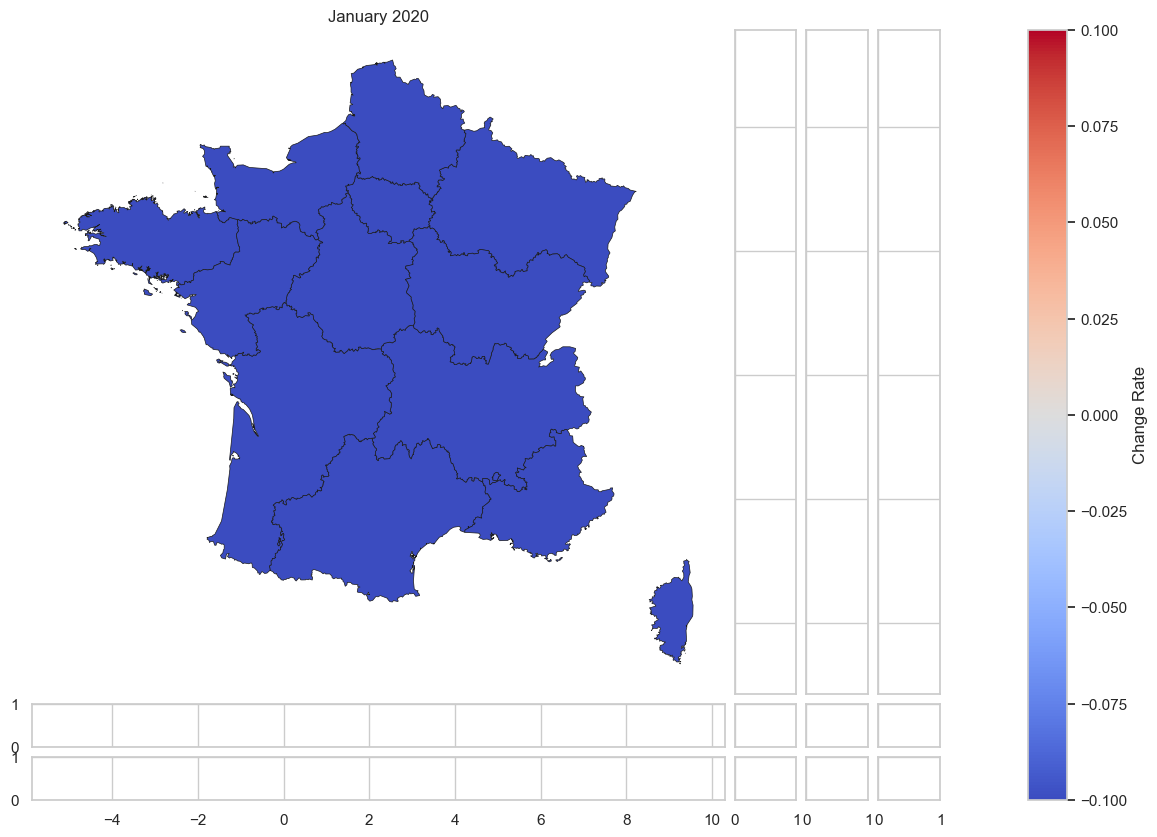

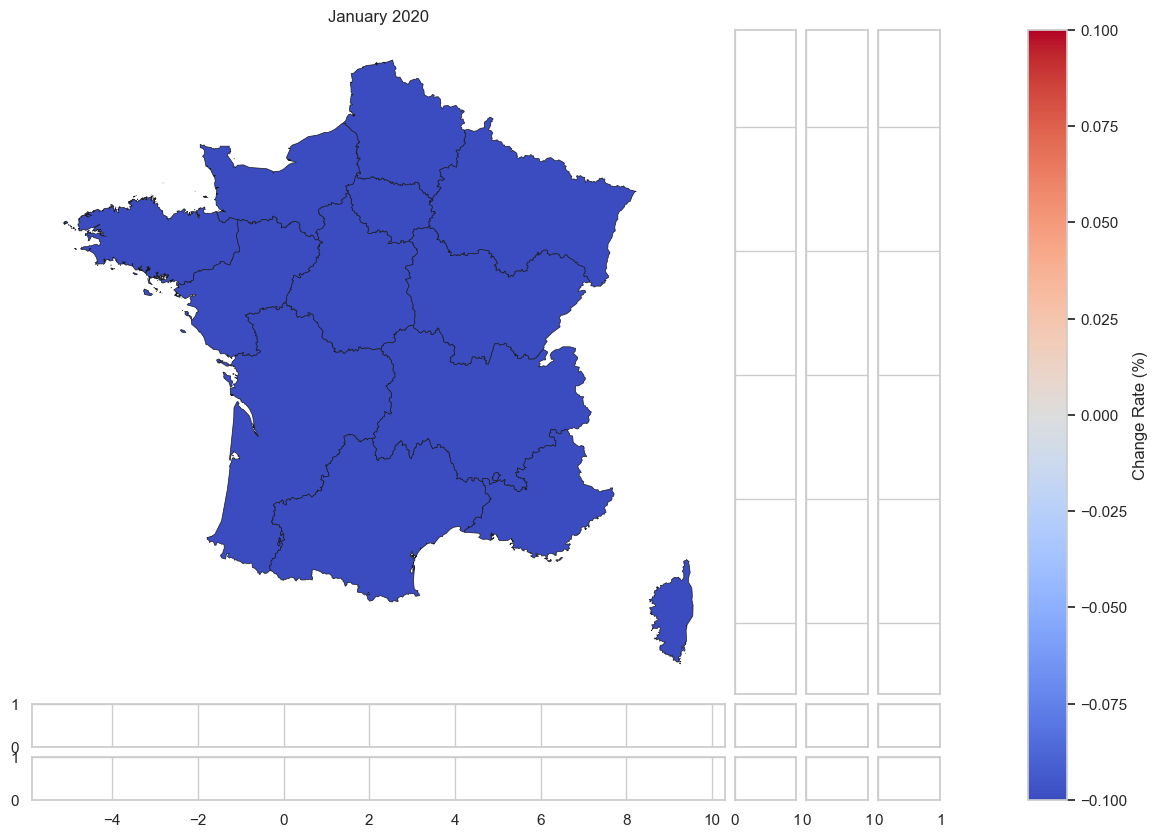

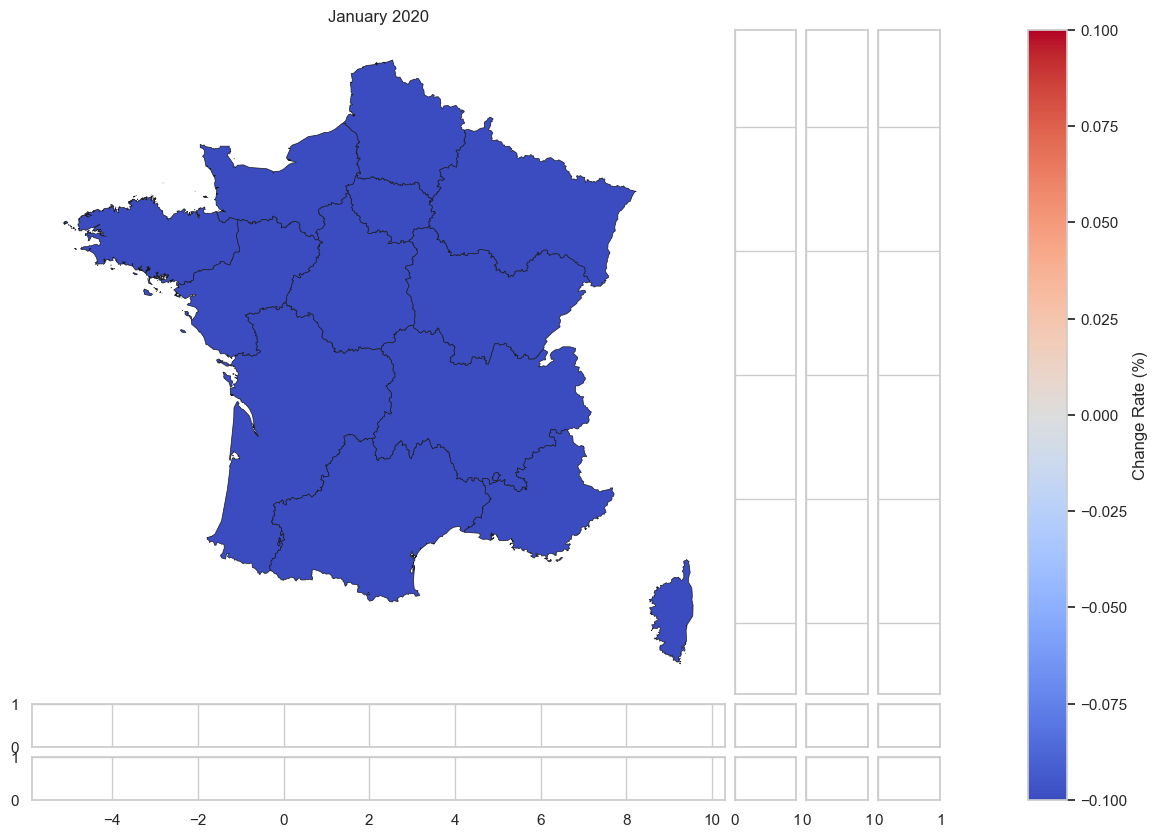

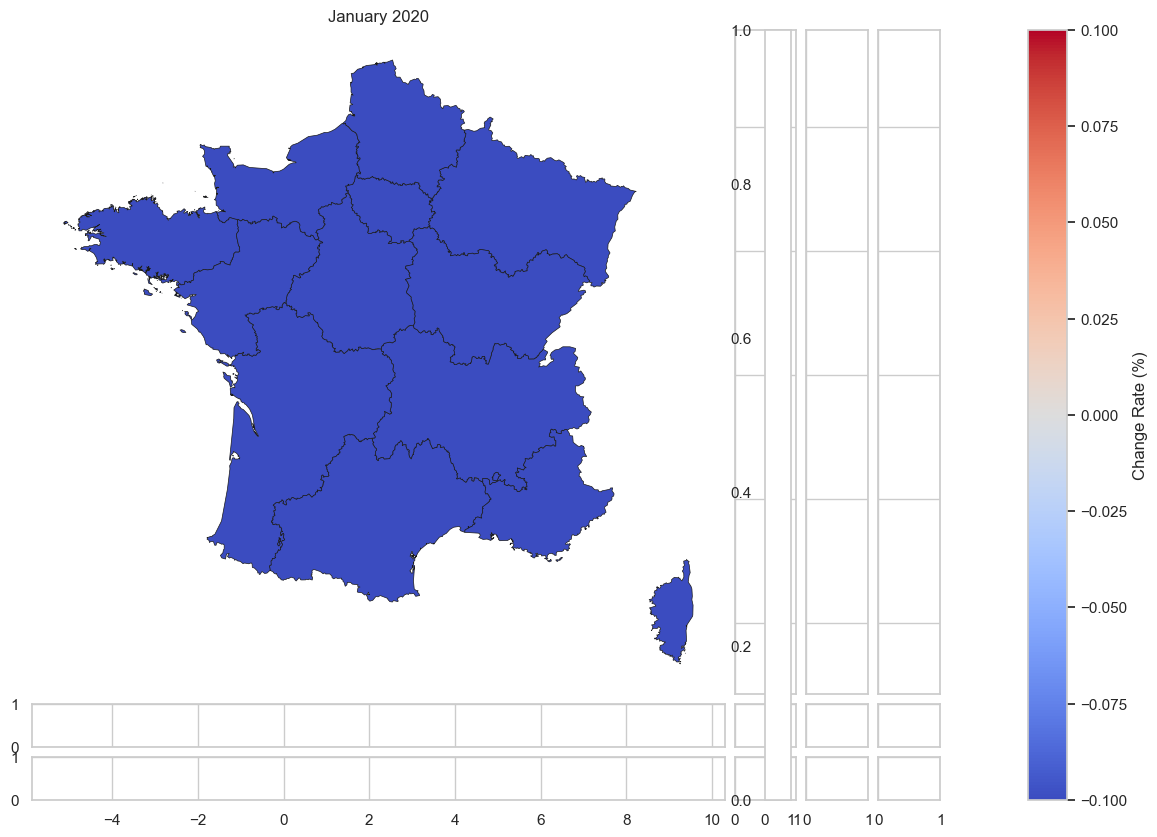

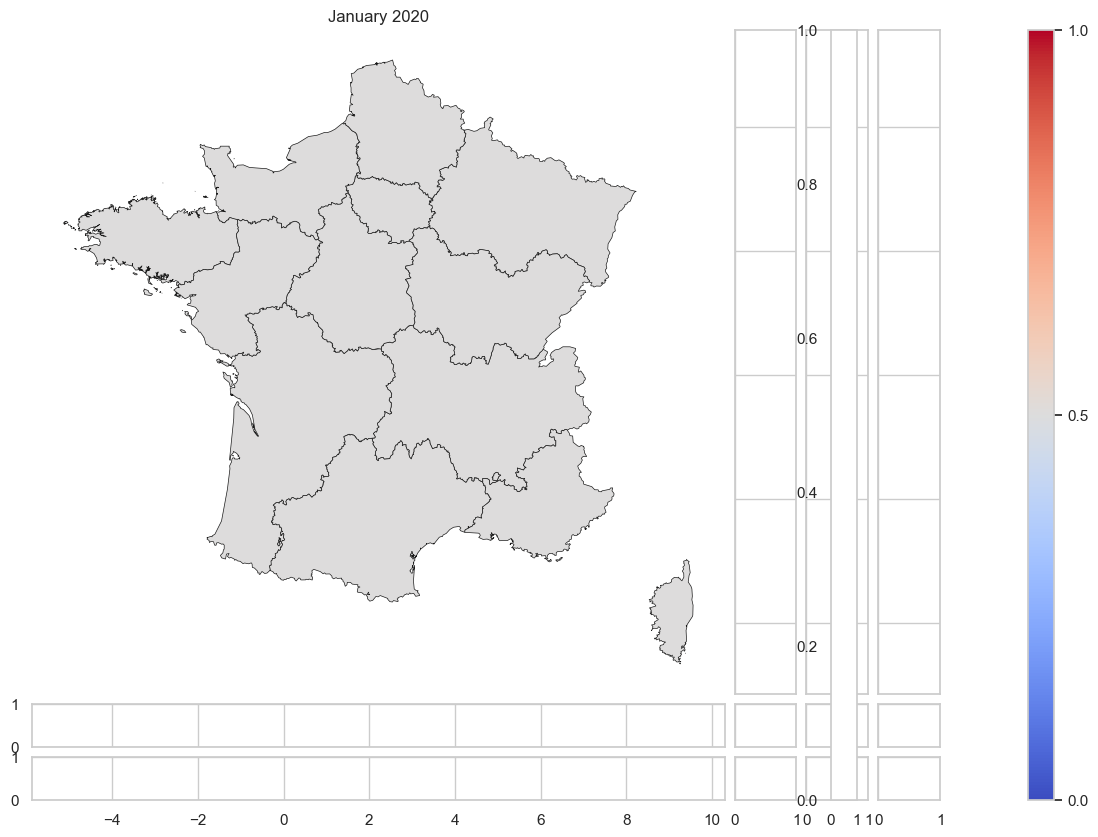

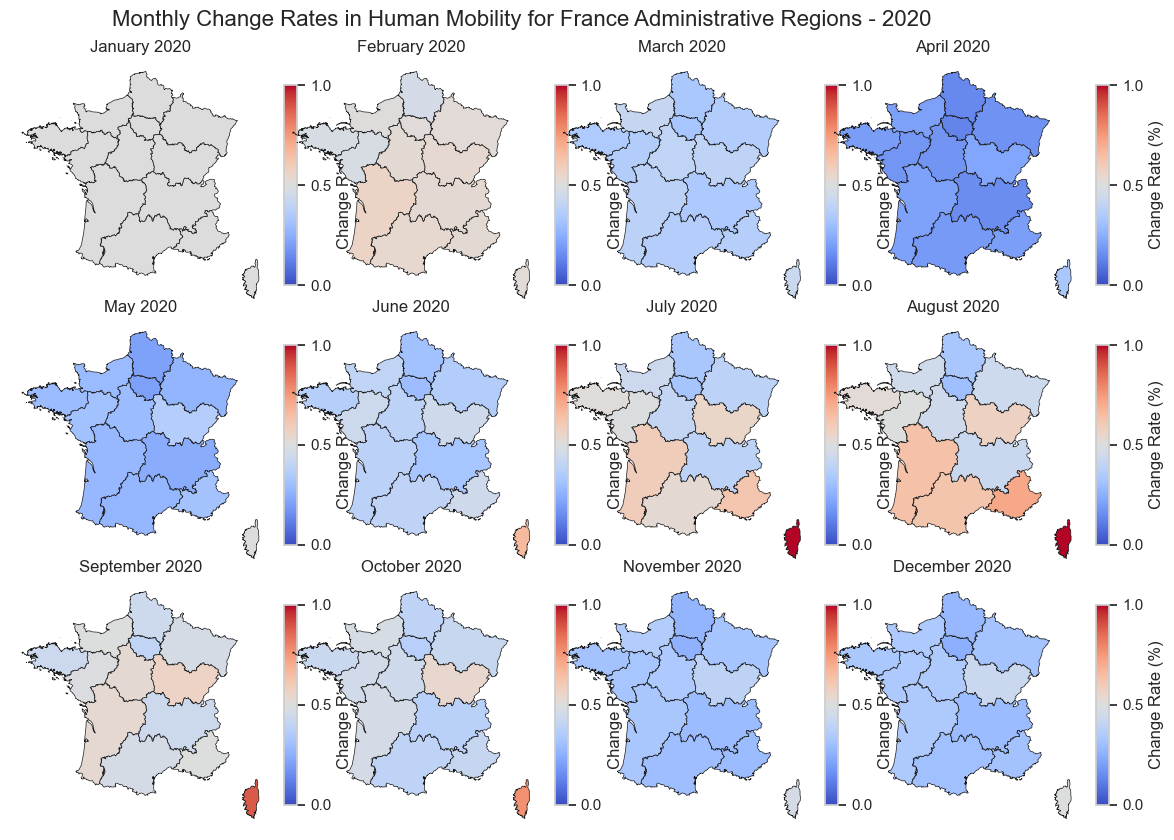

<Figure size 640x480 with 0 Axes>

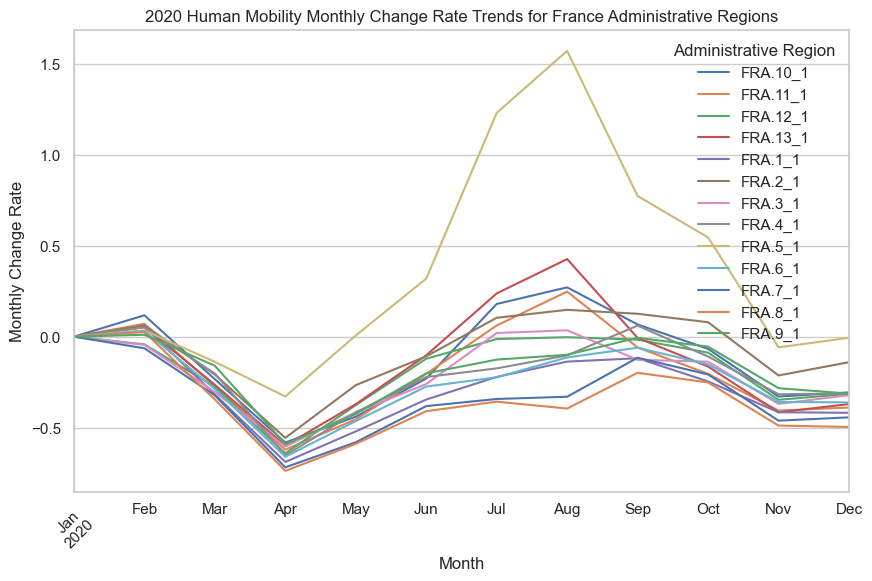

In [839]:
all_code = all_operation_code_str + '\n' + solution.code_for_assembly

# print(solution.code_for_assembly)
display(Code(all_code, language='python'))
# display(Code(all_code, language='python'))
# clear_output(wait=True)
# exec(all_code)
all_code = solution.execute_complete_program(code=all_code, try_cnt=10)
# solution.direct_request_code = code


In [840]:
stop

NameError: name 'stop' is not defined